<a href="https://colab.research.google.com/github/salifsw770/prj_merge/blob/main/VF1_wlfake_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("studymart/welfake-dataset-for-fake-news")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/studymart/welfake-dataset-for-fake-news/versions/1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
print("GPU available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


GPU available: True
Device name: Tesla T4


# Step 1: Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve,  classification_report
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import plotly.express as px
import string
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import plotly.express as px
import string
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


# Step 2: Load Dataset

In [ ]:
data = pd.read_csv(path + '/WELFake_Dataset.csv')

In [ ]:
data.shape

(72134, 4)

In [ ]:
data.head()

Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1

In [ ]:
data.tail()

Unnamed: 0                                              title  \
72129       72129  Russians steal research on Trump in hack of U....   
72130       72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131       72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132       72132  Trump tussle gives unpopular Mexican leader mu...   
72133       72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  
72129  WASHINGTON (Reuters) - Hackers believed to be ...      0  
72130  You know, because in fantasyland Republicans n...      1  
72131  Migrants Refuse To Leave Train At Refugee Camp...      0  
72132  MEXICO CITY (Reuters) - Donald Trump’s combati...      0  
72133  Goldman Sachs Endorses Hillary Clinton For Pre...      1

In [ ]:
data['text'][0] #label 1, Fake News

'No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white people.A 2:39 minute clip from the radio show can be heard here. It was provided to Breitbart Texas by someone who would like to be referred to

In [ ]:
data['text'][72129] #label 1, Fake News

'WASHINGTON (Reuters) - Hackers believed to be working for the Russian government broke into the Democratic National Committee’s computer network, spied on internal communications and accessed research on presumptive Republican presidential nominee Donald Trump, the committee and security experts said on Tuesday. Two separate groups entered the DNC’s system, and one read email and chat communications for nearly a year before being detected, according to the committee and CrowdStrike, the cyber firm that helped clean up the breach. Russian spies also targeted the networks of Trump and Democratic presidential candidate Hillary Clinton, as well as the computers of some Republican political action committees, the Washington Post quoted U.S. officials as saying, although details were not available. A Clinton campaign official said there was no evidence the campaign’s information systems had been hacked. A Russian government spokesman denied involvement in the breach. “I completely rule out 

In [ ]:
data.drop('Unnamed: 0', axis=1, inplace=True)

# Step 3: Handle null values and separate features from labels

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [ ]:
data.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [ ]:
data['text'][4240]

'WASHINGTON (Reuters) - People would be able to bring legal, concealed guns into any U.S. state under legislation the House of Representatives approved on Wednesday that would also bolster the national background check system and require a study of the “bump stocks” used in October’s Las Vegas mass shooting. The country’s long-standing fight over gun ownership has grown more heated since a single person killed 58 people and injured more than 500 at a music festival in Las Vegas, Nevada, the deadliest mass shooting carried out by an individual in U.S. history. Stephen Paddock boosted his firearms with bump stocks to shoot thousands of bullets over 10 minutes. On a vote of 231 to 198, the Republican-led House approved the Concealed Carry Reciprocity Act, which would require states to recognize each others’ permits for carrying hidden and loaded firearms while in public. States’ requirements on concealed guns vary widely. Some states deny permits to people who have committed domestic viol

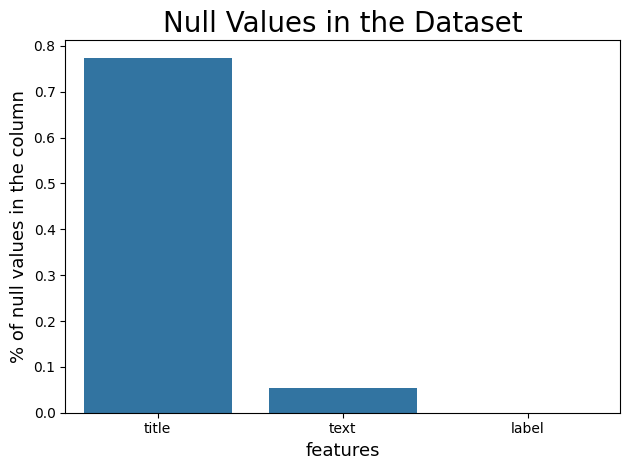

In [ ]:
def plot_nulls(data,title,x_axis_label,y_axis_label):

    # Number of nulls for each column
    data_nulls = (data.apply(lambda x:x.isnull().value_counts()).T[True]/len(data)*100).reset_index(name='count')

    sns.barplot(data_nulls,x="index",y="count")
    plt.title(title,fontsize=20)
    plt.xlabel(x_axis_label,fontsize=13)
    plt.ylabel(y_axis_label,fontsize=13)

    plt.tight_layout()
    plt.show()

plot_nulls(data,"Null Values in the Dataset",'features','% of null values in the column')

In [ ]:
data.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [ ]:
data['title'].fillna(' ',inplace=True)

In [ ]:
data.dropna(subset=["text"], inplace=True)


In [ ]:
data.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [ ]:
data.shape

(72095, 3)

# Remove duplicate values

In [ ]:
data.duplicated().sum()

8456

In [ ]:
data.duplicated(subset=['text']).sum()

9377

In [ ]:
data.drop_duplicates(inplace=True,keep='first')

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
data.shape

(63639, 3)

In [ ]:
data['text'][1]

'Did they post their votes for Hillary already?'

# Valeurs aberrantes

In [ ]:
data.shape

(63639, 3)

# EDA

In [ ]:
data['label'].value_counts()

label
0    34791
1    28848
Name: count, dtype: int64

In [ ]:
label_Status = data['label'].value_counts()
transactions = label_Status.index
quantity = label_Status.values

figure = px.pie(data,
             values=quantity,
             names=transactions, hole =.60,
             title="Fake & Real")
figure.show()

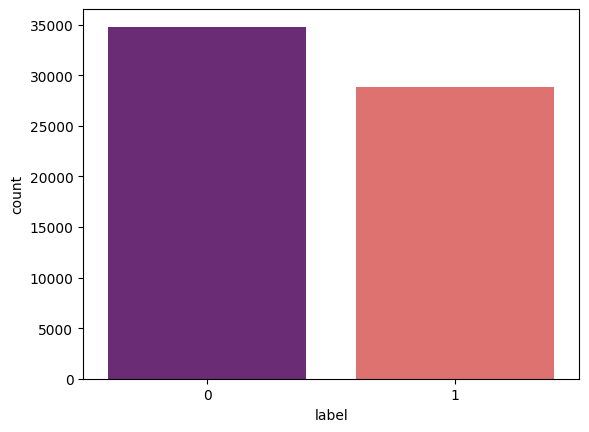

In [ ]:
sns.countplot(x = 'label', data = data,palette = 'magma')
plt.show()

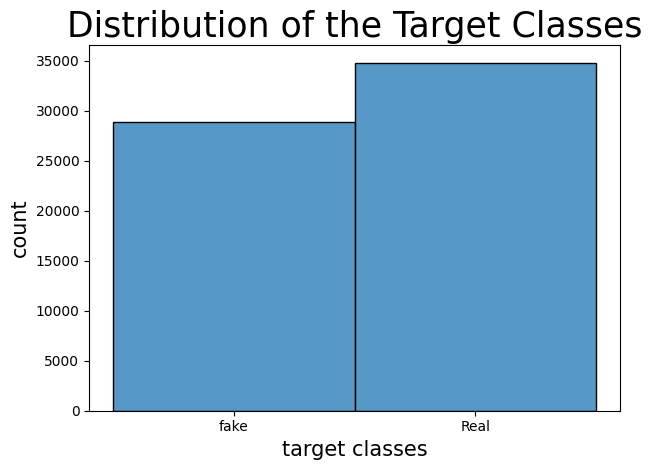

In [ ]:
# Creating a column with 'readable' labels for the news

news_map = {1:'fake',0:'Real'}
data['label_names'] = data['label'].map(news_map)

sns.histplot(data=data.label_names)
plt.title('Distribution of the Target Classes',fontsize=25)
plt.xlabel('target classes',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.tight_layout()

# Feature Engineering

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Exploratory Data Analysis



# Step 4: Create word clouds

In [ ]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)

fake_text = ' '.join(data[data['label'] == 1]['text'])
real_text = ' '.join(data[data['label'] == 0]['text'])

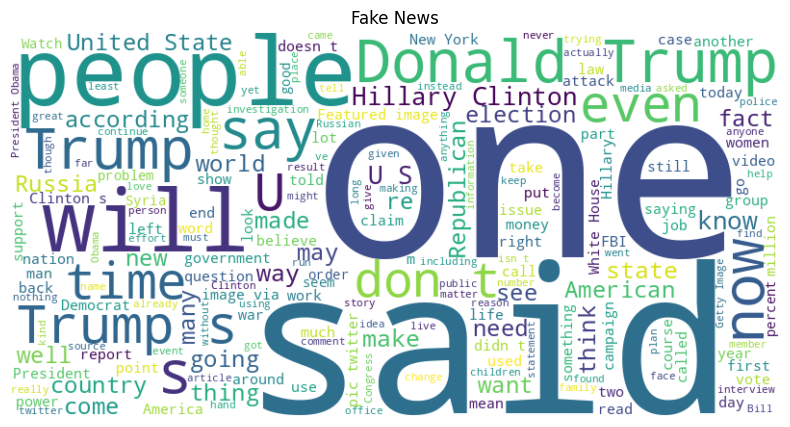

In [ ]:
plot_wordcloud(fake_text, 'Fake News')
plt.show()

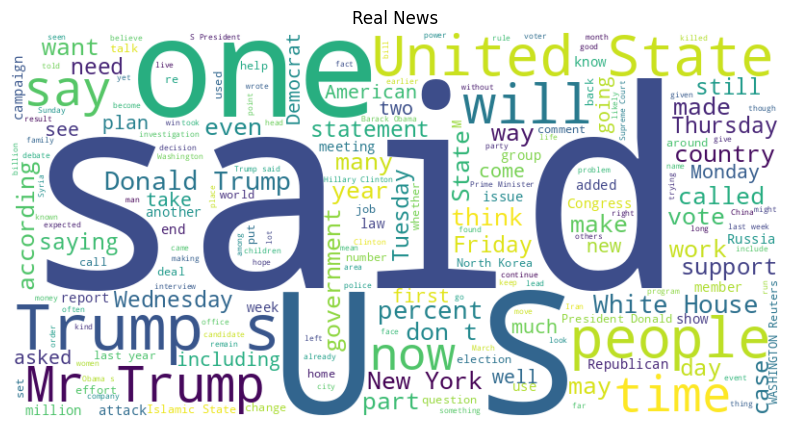

In [ ]:
plot_wordcloud(real_text, 'Real News')
plt.show()

# Step 5: Text preprocessing

# Removing Stopwords and punctuation

In [ ]:
data['final_text'] = data['title'] + ' ' + data['text']

In [ ]:
text_column = 'final_text'
label_column = 'label'

In [ ]:
import nltk
import re
nltk.download('punkt_tab')
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
stopword



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
data['text'][6277]

'MOSCOW (Reuters) - Kremlin spokesman Dmitry Peskov said on Friday it was not yet known if Russian President Vladimir Putin will run for re-election when his term ends next year. Peskov said Putin met former finance minister Alexei Kudrin to talk about a strategy for economic development up to 2024. Asked if Kudrin was helping draft Putin s program for the next term, Peskov told reporters:  It is now yet known if Putin will run for the next presidential term.  The next six-year term expires in 2024. '

In [ ]:
data['text'][4240]

'BERLIN (Reuters) - A decision by U.S. President Donald Trump to withdraw from the Paris climate agreement would not send a good signal for a separate deal agreed last year that seeks to curb aviation emissions, global airlines body IATA said on Thursday. Aviation is not part of the Paris accord to fight climate change but the industry last year agreed its own deal to combat aviation pollution, also known as the Carbon Offset and Reduction Scheme for International Aviation (CORSIA). “Any decision to withdraw from the Paris agreement by the U.S. is not sending a good signal, even if the U.S. could remain in CORSIA and withdraw from the Paris agreement. But it’s not decided and the two are completely separate,” IATA director general Alexandre de Juniac said on Thursday.   '

In [ ]:
# removing news source info from text
def extract_txt(text):
    regex = re.search(r"(?<=\(Reuters\)\s\-\s).*",text)
    if regex:
        return regex.group(0)
    return text


In [ ]:
data[text_column] = data[text_column].apply(extract_txt)

In [ ]:
data[text_column][3]

'Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid A dozen politically active pastors came here for a private dinner Friday night to hear a conversion story unique in the context of presidential politics: how Louisiana Gov. Bobby Jindal traveled from Hinduism to Protestant Christianity and, ultimately, became what he calls an “evangelical Catholic.”\n\nOver two hours, Jindal, 42, recalled talking with a girl in high school who wanted to “save my soul,” reading the Bible in a closet so his parents would not see him and feeling a stir while watching a movie during his senior year that depicted Jesus on the cross.\n\n“I was struck, and struck hard,” Jindal told the pastors. “This was the Son of God, and He had died for our sins.”\n\nJindal’s session with the Christian clergy, who lead congregations in the early presidential battleground states of Iowa and South Carolina, was part of a behind-the-scenes effort by the Louisiana governo

In [ ]:
data[text_column][4240]

'A decision by U.S. President Donald Trump to withdraw from the Paris climate agreement would not send a good signal for a separate deal agreed last year that seeks to curb aviation emissions, global airlines body IATA said on Thursday. Aviation is not part of the Paris accord to fight climate change but the industry last year agreed its own deal to combat aviation pollution, also known as the Carbon Offset and Reduction Scheme for International Aviation (CORSIA). “Any decision to withdraw from the Paris agreement by the U.S. is not sending a good signal, even if the U.S. could remain in CORSIA and withdraw from the Paris agreement. But it’s not decided and the two are completely separate,” IATA director general Alexandre de Juniac said on Thursday.   '

In [ ]:
data[text_column][6312]

'A French-backed West African military force to tackle Islamist militants must secure its first victories by the middle of 2018 to prove its worth and ensure more concrete support from the United Nations, the French and Malian leaders said on Wednesday.  The G5 Sahel - composed of the armies of Mali, Mauritania, Niger, Burkina Faso and Chad - launched a symbolic military operation to mark its creation in October amid growing unrest in the region, whose porous borders are regularly crossed by jihadists, including affiliates of al Qaeda and Islamic State. However, France which has some 4,000 troops in the region, has bemoaned that the militants have scored military and symbolic victories in West Africa while the G5 force has struggled to win financing and become operational. To give the force a boost, French President Emmanuel Macron hosted the leaders of the five participating countries, Germany and Italy as well as the Saudi and Emirati ministers at a summit. In a sign Gulf Arab states

In [ ]:
data[text_column].isnull().sum()

0

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from tqdm import tqdm
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from wordcloud import WordCloud

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text_data):
    preprocessed_text = []
    for sentence in tqdm(text_data):
        sentence = re.sub('[^a-zA-Z0-9]', ' ', sentence)  # Suppression des caractères non alphanumériques sauf les nombres
        sentence = sentence.lower()
        words = nltk.word_tokenize(sentence)
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        preprocessed_text.append(' '.join(words))
    return preprocessed_text



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Appliquer à la colonne 'text'
data[text_column] = preprocess_text(data[text_column])

100%|██████████| 63639/63639 [03:32<00:00, 299.27it/s]


In [ ]:
data['text'].shape

(63639,)

In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
data[text_column][3]

'bobby jindal raised hindu us story christian conversion woo evangelicals potential 2016 bid dozen politically active pastor came private dinner friday night hear conversion story unique context presidential politics louisiana gov bobby jindal traveled hinduism protestant christianity ultimately became call evangelical catholic two hour jindal 42 recalled talking girl high school wanted save soul reading bible closet parent would see feeling stir watching movie senior year depicted jesus cross struck struck hard jindal told pastor son god died sin jindal session christian clergy lead congregation early presidential battleground state iowa south carolina part behind scene effort louisiana governor find political base could help propel top tier republican candidate seeking run white house 2016 known gop circle mostly mastery policy issue health care jindal rhodes scholar graduate ivy league brown university obvious pool activist supporter help drive excitement outside home state harnessi

# WordCloud

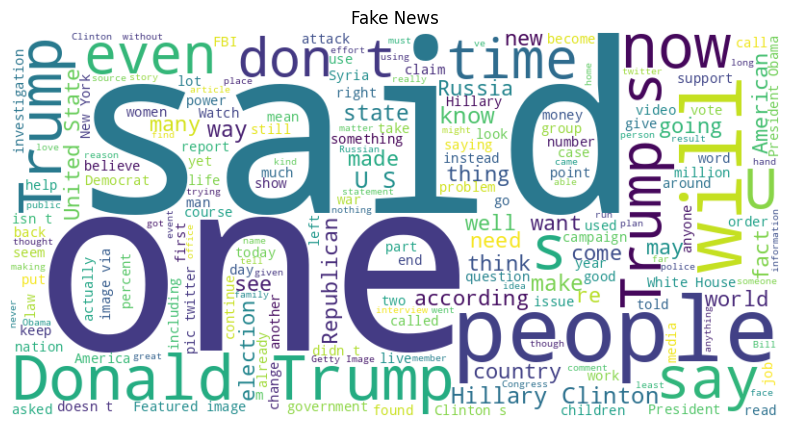

In [ ]:
plot_wordcloud(fake_text, 'Fake News')
plt.show()

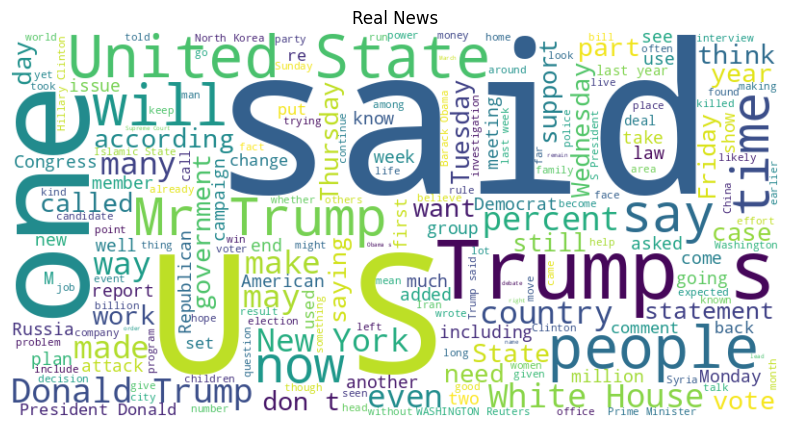

In [ ]:
plot_wordcloud(real_text, 'Real News')
plt.show()

In [ ]:
data[text_column][4240]

'decision u president donald trump withdraw paris climate agreement would send good signal separate deal agreed last year seek curb aviation emission global airline body iata said thursday aviation part paris accord fight climate change industry last year agreed deal combat aviation pollution also known carbon offset reduction scheme international aviation corsia decision withdraw paris agreement u sending good signal even u could remain corsia withdraw paris agreement decided two completely separate iata director general alexandre de juniac said thursday'

In [ ]:
data[text_column]

0        law enforcement high alert following threat co...
1                                post vote hillary already
2        unbelievable obama attorney general say charlo...
3        bobby jindal raised hindu us story christian c...
4        satan 2 russia unvelis image terrifying new su...
                               ...                        
63634    wikileaks email show clinton foundation fund u...
63635    hacker believed working russian government bro...
63636    watch giuliani demand democrat apologize trump...
63637    migrant refuse leave train refugee camp hungar...
63638    donald trump combative style buffeted mexico p...
Name: final_text, Length: 63639, dtype: object

# Step 7: Word Embbeding Glove

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Paramètres globaux
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 800
EMBEDDING_DIM = 100  # Dimension des embeddings (GloVe)
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 128
EPOCHS = 10

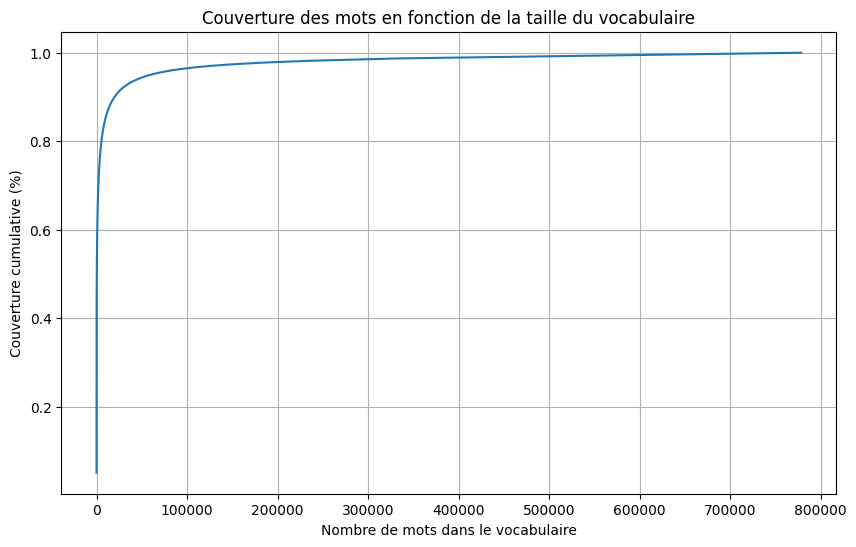

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Extraire tous les mots du corpus
all_words = ' '.join(data['text']).split()
word_freq = Counter(all_words)

# Trier les mots par fréquence
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Calculer la couverture cumulative
total_words = sum(word_freq.values())
coverage = []
cumulative_sum = 0

for word, freq in sorted_words:
    cumulative_sum += freq
    coverage.append(cumulative_sum / total_words)

# Tracer la courbe de couverture
plt.figure(figsize=(10, 6))
plt.plot(range(len(coverage)), coverage)
plt.xlabel("Nombre de mots dans le vocabulaire")
plt.ylabel("Couverture cumulative (%)")
plt.title("Couverture des mots en fonction de la taille du vocabulaire")
plt.grid()
plt.show()




In [ ]:
# Recommandation de tailles de vocabulaire
for threshold in [0.85, 0.90, 0.95, 0.99]:
    idx = next(i for i, cov in enumerate(coverage) if cov >= threshold)
    print(f"Taille du vocabulaire pour {int(threshold * 100)}% de couverture : {idx}")

Taille du vocabulaire pour 85% de couverture : 9681
Taille du vocabulaire pour 90% de couverture : 19883
Taille du vocabulaire pour 95% de couverture : 59453
Taille du vocabulaire pour 99% de couverture : 433071


In [ ]:
# 2. Créer un Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,oov_token="<OOV>")
tokenizer.fit_on_texts(data[text_column])

In [ ]:
len(tokenizer.word_index)

201511

In [ ]:
sequences = tokenizer.texts_to_sequences(data[text_column])
word_index = tokenizer.word_index

In [ ]:
# Calcul des longueurs des séquences
sequence_lengths = [len(seq) for seq in sequences]

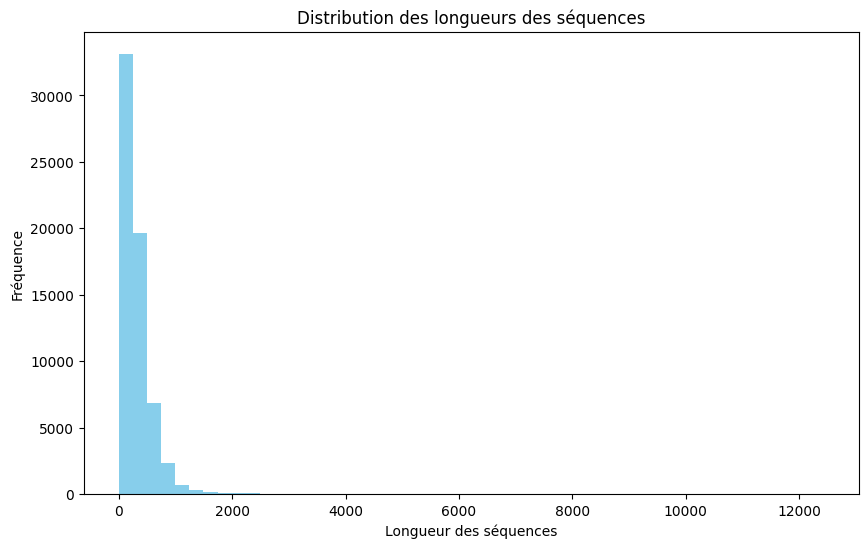

In [ ]:
# Visualisation de la distribution des longueurs
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=50, color='skyblue')
plt.title("Distribution des longueurs des séquences")
plt.xlabel("Longueur des séquences")
plt.ylabel("Fréquence")
plt.show()

In [ ]:
# Calcul des percentiles
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    print(f"{p}e percentile: {np.percentile(sequence_lengths, p)}")

# Recommandation de max_length (par exemple, 95% des séquences)
max_length = int(np.percentile(sequence_lengths, 95))
print(f"Longueur maximale recommandée : {max_length}")

50e percentile: 241.0
75e percentile: 399.0
90e percentile: 640.0
95e percentile: 803.0
99e percentile: 1501.0
Longueur maximale recommandée : 803


In [ ]:
word_index


{'<OOV>': 1,
 'said': 2,
 'trump': 3,
 'u': 4,
 'state': 5,
 'would': 6,
 'president': 7,
 'one': 8,
 'people': 9,
 'year': 10,
 'mr': 11,
 'new': 12,
 'time': 13,
 'clinton': 14,
 'republican': 15,
 'also': 16,
 'like': 17,
 'american': 18,
 'government': 19,
 'obama': 20,
 'say': 21,
 'could': 22,
 'country': 23,
 'house': 24,
 'election': 25,
 'campaign': 26,
 'two': 27,
 'right': 28,
 'donald': 29,
 'even': 30,
 'party': 31,
 'united': 32,
 'first': 33,
 'day': 34,
 'last': 35,
 'many': 36,
 'white': 37,
 'news': 38,
 'make': 39,
 'get': 40,
 'told': 41,
 'hillary': 42,
 'official': 43,
 'group': 44,
 'law': 45,
 'way': 46,
 'may': 47,
 'want': 48,
 'world': 49,
 'week': 50,
 'know': 51,
 'woman': 52,
 'going': 53,
 'think': 54,
 'former': 55,
 'made': 56,
 'political': 57,
 'vote': 58,
 'back': 59,
 'medium': 60,
 'take': 61,
 'national': 62,
 'percent': 63,
 'million': 64,
 'since': 65,
 'police': 66,
 'well': 67,
 'russia': 68,
 'court': 69,
 'security': 70,
 'month': 71,
 'go':

In [ ]:
word_index['dozen']

916

In [ ]:
data[text_column][56]

'internationally backed libyan force attack daesh position sirte fighter loyal libya un backed government guard look point city sirte east tripoli try clear last remaining daesh terrorist al jiza al bahriya neighborhood october 26 2016 photo afp libyan force launched fresh offensive daesh position mediterranean port city sirte thursday fighter nearby city misrata allied force un backed unity government tripoli pushing way last pocket resistance city ghiza bahriya district supported tank armored vehicle renewed offensive bonyan marsous force libyan army force advancing onto ghiza bahriya free bonyan force advancing ghiza bahriya thank god causality far wounded said hussien edra member bonyan marsous brigade may internationally backed pro government troop started large scale military operation including street street fighting backed heavy airstrikes artillery fire eradicate daesh militant sirte far recaptured area city daesh commander city fled place remaining rank holding via sniper fir

In [ ]:
word_index['unworkable']

19371

In [ ]:
sequences[56]

[5426,
 820,
 3990,
 118,
 91,
 4478,
 365,
 12799,
 1156,
 3607,
 1420,
 978,
 820,
 19,
 1311,
 167,
 136,
 92,
 12799,
 539,
 8026,
 492,
 263,
 35,
 2182,
 4478,
 389,
 338,
 1,
 338,
 1,
 1575,
 431,
 1166,
 100,
 727,
 6379,
 3990,
 118,
 1507,
 2566,
 1656,
 4478,
 365,
 4721,
 2333,
 92,
 12799,
 185,
 1156,
 2238,
 92,
 1,
 3764,
 118,
 978,
 820,
 2475,
 19,
 8026,
 1679,
 46,
 35,
 2989,
 2243,
 92,
 1,
 1,
 624,
 1190,
 1907,
 6170,
 1054,
 3761,
 1656,
 1,
 1,
 118,
 3990,
 610,
 118,
 5609,
 1980,
 1,
 1,
 271,
 1,
 118,
 5609,
 1,
 1,
 1729,
 804,
 1,
 180,
 2041,
 2,
 1,
 1,
 99,
 1,
 1,
 6323,
 47,
 5426,
 820,
 821,
 19,
 945,
 666,
 509,
 1911,
 112,
 504,
 97,
 330,
 330,
 751,
 820,
 1867,
 3539,
 6569,
 580,
 11074,
 4478,
 795,
 12799,
 180,
 14259,
 285,
 92,
 4478,
 1476,
 92,
 2453,
 160,
 2182,
 2556,
 1029,
 198,
 6278,
 580,
 17678,
 6183,
 630,
 1178,
 12799,
 626,
 831,
 1,
 795,
 44,
 515,
 449,
 209,
 99,
 118,
 3607,
 1420,
 978,
 820,
 19,
 4232,
 550

In [ ]:
sequences[1]

[186, 58, 42, 207]

In [ ]:
data[text_column][1]

'post vote hillary already'

In [ ]:
# Padding des séquences
data_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [ ]:
data_padded.shape

(63639, 800)

In [ ]:
data_padded[52]

array([ 9355,  1901,   266, 11914,   452,  2419,    12,    77,    13,
        9321,   449,    27,    10,   342,   654,  2515,  1674,  1046,
           1,     1,  2453,  1642,   583,  1901,   166,  5170,  1841,
         162,   411,    24,  4305, 10518, 13782,   683,   350,   787,
        1061,    70,   118,  1475,  1901,  3827,   315,     5,   118,
           1,   452,   563, 11441,   492,   524,     1,  1993,    92,
        2769,   199,  1089,     1,    13,   184,   654,    17,  1045,
           2,     1,     1,  5313,   175,   436,  1901,   285,     2,
           6,    53,    59,   632, 11628,     1,  1134,   449,   531,
        7854,  8754,   151,   217,   727, 17050,  6005, 13340,  3007,
           1,   911,  3190,  1088,  1901,   287,     1,  1169,    36,
        2956,  1230,    39,  1901,   784,    21,   138,    72,   151,
          30,   758,  7879,  4921,   315,     5,  3721,   458,    27,
          10,   342,  1901,   449,  3427,    92,  1228,  1110,  8378,
          59,  3391,

In [ ]:
data_padded[44]


array([    4,     7,  1060,    29,     3,     2,  1235,     6,   470,
         235,    81,    23,     6,   600,   594,   363,   362,  1288,
         856,  4505,  3789,   278,   144,    32,  2442,   656,   210,
          13,  1035,  1118,   375,    34,  1703,     3,   742,   242,
        1172,   594,  2315,    35,    10,    58,   533,   363,   362,
          54,  1235,    53,   153,   235,    81,     3,     2,   384,
         155,  3081,  6737,  1111,   235,   146,  5725,   273,    88,
        1768,   559,  1411,    58,   196,    36,  1302,   225,   243,
        1515,  8003,  9294,    57,   415,  4860,   594,    65,    49,
          78,    27,   802,   312,     8,    34,   899,  6737,   542,
        6737,    65,  2974,     4,   542,  5506,   146,  1302, 16915,
        1265,   705,   594,   802,   745,  2503,   879,  1982,  2019,
           3,    25,    26,  2631,  1235,    58,   558, 12422,   121,
        1754,    57,   848,  8105,  4710,   770,  1235,  6692,  8439,
        6093,  4149,

In [ ]:
data[text_column][39789]

'beyond sick cnn run segment explain obama appointee take president trump penny assassinated inauguration video'

In [ ]:
sequence_lengths[21989]

32

In [ ]:
# Inversion du dictionnaire
index_word = {index: word for word, index in word_index.items()}
print(index_word)



{1: '<OOV>', 2: 'said', 3: 'trump', 4: 'u', 5: 'state', 6: 'would', 7: 'president', 8: 'one', 9: 'people', 10: 'year', 11: 'mr', 12: 'new', 13: 'time', 14: 'clinton', 15: 'republican', 16: 'also', 17: 'like', 18: 'american', 19: 'government', 20: 'obama', 21: 'say', 22: 'could', 23: 'country', 24: 'house', 25: 'election', 26: 'campaign', 27: 'two', 28: 'right', 29: 'donald', 30: 'even', 31: 'party', 32: 'united', 33: 'first', 34: 'day', 35: 'last', 36: 'many', 37: 'white', 38: 'news', 39: 'make', 40: 'get', 41: 'told', 42: 'hillary', 43: 'official', 44: 'group', 45: 'law', 46: 'way', 47: 'may', 48: 'want', 49: 'world', 50: 'week', 51: 'know', 52: 'woman', 53: 'going', 54: 'think', 55: 'former', 56: 'made', 57: 'political', 58: 'vote', 59: 'back', 60: 'medium', 61: 'take', 62: 'national', 63: 'percent', 64: 'million', 65: 'since', 66: 'police', 67: 'well', 68: 'russia', 69: 'court', 70: 'security', 71: 'month', 72: 'go', 73: 'policy', 74: 'according', 75: 'support', 76: 'democrat', 77: 

In [ ]:
index = 0
word = index_word.get(index, "Mot introuvable")  # "Mot introuvable" si l'index n'existe pas
print(f"Le mot correspondant à l'index {index} est : {word}")

Le mot correspondant à l'index 0 est : Mot introuvable


In [ ]:
word_index['simulator']

24206

In [ ]:
embedding_dict={}
with open('/content/drive/MyDrive/dataset/glove.6B.100d.txt',  'r') as f :
    for line in f :
        values= line.split()
        word=values[0]
        vector = np.asarray(values[1:] , 'float32')
        embedding_dict[word] = vector
f.close()

In [ ]:
num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in tqdm(word_index.items()):
    if i >= num_words:
        continue
    embed_vector = embedding_dict.get(word)
    if embed_vector is not None:
        embedding_matrix[i] = embed_vector


100%|██████████| 201511/201511 [00:00<00:00, 1750995.23it/s]


In [ ]:
embed_vector = embedding_dict.get('simulator')


In [ ]:
word_index['simulator']

24206

In [ ]:
embedding_matrix[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
len(word_index)+1

201512

In [ ]:
embedding_matrix.shape

(20000, 100)

In [ ]:
(embedding_matrix[6]==embedding_matrix[6]).all()

True

In [ ]:
from keras.layers import Embedding , Dense , LSTM , SpatialDropout1D
from keras.models import Sequential
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import gensim
from keras.models import Model
from keras.layers import Dense, Embedding, Input,LSTM, Bidirectional, GlobalMaxPool1D, Dropout

In [ ]:
embedding_matrix.shape

(20000, 100)

In [ ]:
embedding_matrix.shape

(20000, 100)

# SPLIT DATA

In [ ]:
y = data[label_column]
X = data_padded

In [ ]:
# 5. Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)



In [ ]:
X_train.shape,X_test.shape

((44547, 800), (19092, 800))

# LSTM

In [ ]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)
print('Building model with LSTM...')

input_l = Input(shape=(MAX_SEQUENCE_LENGTH,))
a = embedding_layer(input_l)  # Assurez-vous que cette couche est bien définie
a = SpatialDropout1D(0.2)(a)  # Application de SpatialDropout1D après l'embedding
a = LSTM(100, return_sequences=True)(a)
a=Dropout(0.5)(a)
a = GlobalMaxPool1D()(a)
outputl = Dense(1, activation="sigmoid")(a)

model_lstm = Model(input_l, outputl)

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm.summary()


Building model with LSTM...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 800, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 800, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 800, 100)            │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 800, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 100)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,080,501 (7.94 MB)

 Trainable params: 80,501 (314.46 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [ ]:
# Entraîner le modèle
history_lstm = model_lstm.fit(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=10,
  validation_split=VALIDATION_SPLIT
)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.7544 - loss: 0.4801 - val_accuracy: 0.9122 - val_loss: 0.3124
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.9127 - loss: 0.2165 - val_accuracy: 0.9484 - val_loss: 0.2017
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.9402 - loss: 0.1532 - val_accuracy: 0.9596 - val_loss: 0.1705
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9555 - loss: 0.1177 - val_accuracy: 0.9639 - val_loss: 0.1394
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.9642 - loss: 0.0935 - val_accuracy: 0.9626 - val_loss: 0.1309
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9676 - loss: 0.0842 - val_accuracy: 0.9701 - val_loss: 0.1106
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9702 - loss: 0.0788 - val_accuracy: 0.9731 - val_loss: 0.1022
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.9743 - loss: 0.0682 - 

# Evaluete LSTM

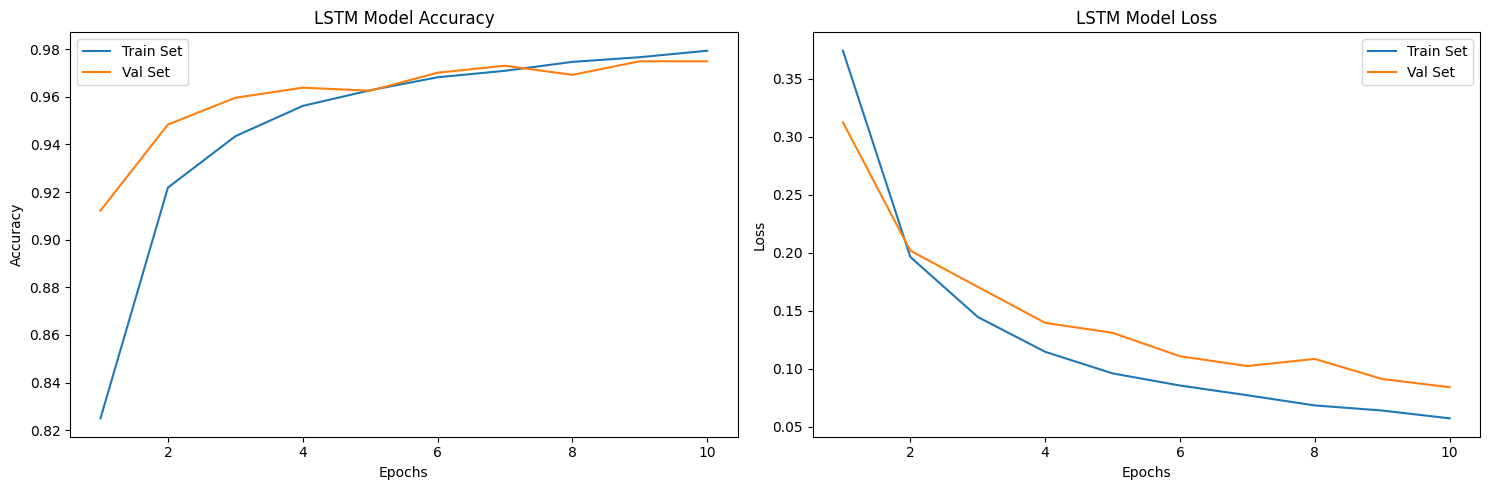

In [ ]:
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
epochs_range = range(1, len(history_lstm.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss')

plt.tight_layout()
plt.show()

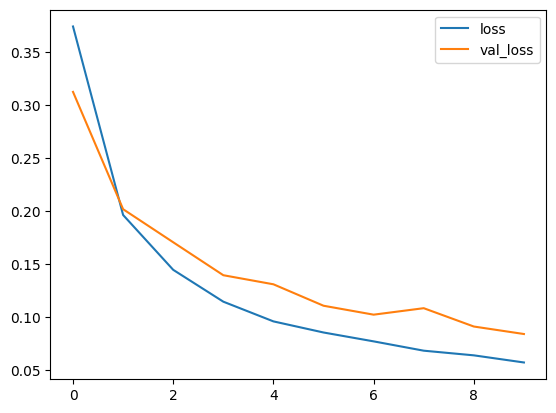

In [ ]:
# plot some data
plt.plot(history_lstm.history['loss'], label='loss')
plt.plot(history_lstm.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

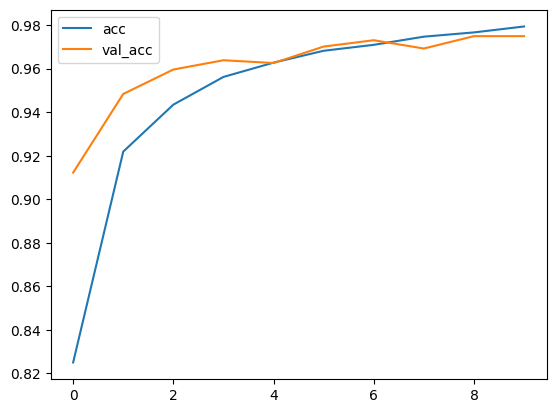

In [ ]:
# Plotting accuracies
plt.plot(history_lstm.history['accuracy'], label='acc')
plt.plot(history_lstm.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
print("Accuracy of the model on Training Data is - " , model_lstm.evaluate(X_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model_lstm.evaluate(X_test,y_test)[1]*100)

1393/1393 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.9864 - loss: 0.0654
Accuracy of the model on Training Data is -  98.33210110664368
597/597 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9727 - loss: 0.0873
Accuracy of the model on Testing Data is -  97.38110303878784


# Confusion Matrix

In [ ]:
y_predlstm = model_lstm.predict(X_test)
y_predlstm[:5]

597/597 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


array([[0.01169411],
       [0.01263511],
       [0.25973347],
       [0.99730945],
       [0.9977102 ]], dtype=float32)

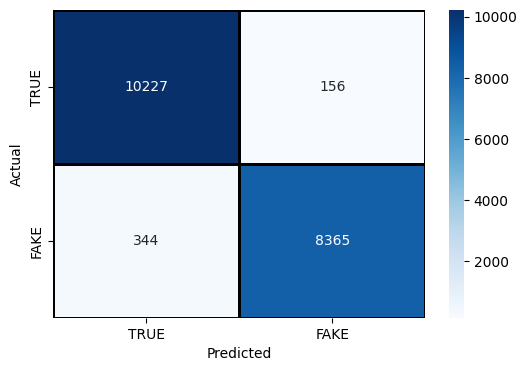

In [ ]:
cm_lstm = confusion_matrix(y_test,y_predlstm.round())
cm_lstm= pd.DataFrame(cm_lstm , index = ['TRUE','FAKE'] , columns = ['TRUE','FAKE'])
plt.figure(figsize = (6,4))
sns.heatmap(cm_lstm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['TRUE','FAKE'] , yticklabels = ['TRUE','FAKE'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test,y_predlstm.round()))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     10383
           1       0.98      0.96      0.97      8709

    accuracy                           0.97     19092
   macro avg       0.97      0.97      0.97     19092
weighted avg       0.97      0.97      0.97     19092



# BILSTM

In [ ]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.5)(x)  # Désactive 30% des neurones
x = GlobalMaxPool1D()(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Building model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 800, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 800, 100)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 800, 256)            │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 800, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,234,753 (8.52 MB)

 Trainable params: 234,753 (917.00 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
print('Training model...')
r = model.fit(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 38s 143ms/step - accuracy: 0.7961 - loss: 0.4241 - val_accuracy: 0.9159 - val_loss: 0.2560
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 34s 140ms/step - accuracy: 0.9314 - loss: 0.1735 - val_accuracy: 0.9585 - val_loss: 0.1477
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.9583 - loss: 0.1095 - val_accuracy: 0.9650 - val_loss: 0.1258
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.9636 - loss: 0.0965 - val_accuracy: 0.9659 - val_loss: 0.1141
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.9710 - loss: 0.0797 - val_accuracy: 0.9722 - val_loss: 0.1127
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.9757 - loss: 0.0681 - val_accuracy: 0.9720 - val_loss: 0.0970
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.9774 - loss: 0.0611 - val_accuracy: 0.9764 - val_loss: 0.0864
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy

In [ ]:
X_train.shape

(44547, 800)

# Step 09: Evaluate BILSTM

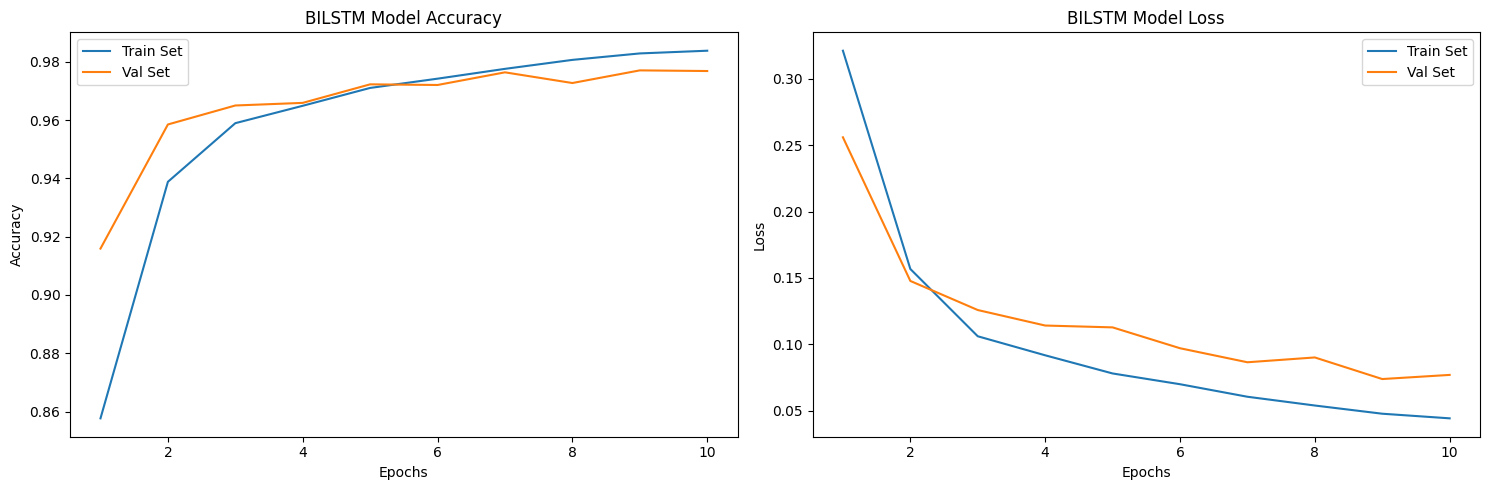

In [ ]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs_range = range(1, len(r.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BILSTM Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BILSTM Model Loss')

plt.tight_layout()
plt.show()

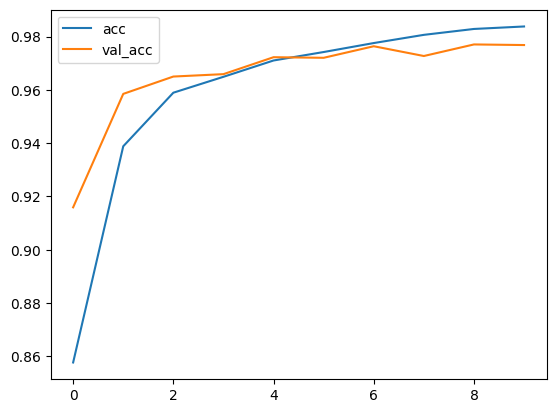

In [ ]:
# Plotting accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

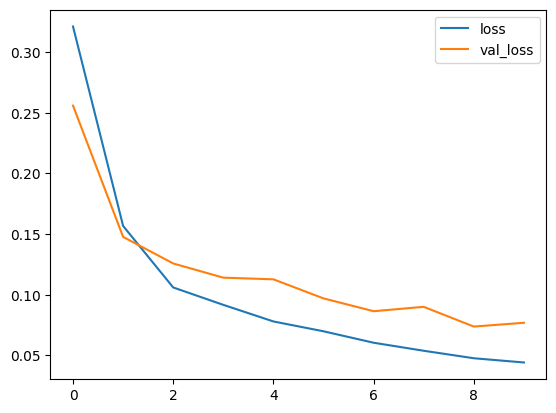

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

1393/1393 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.9925 - loss: 0.0539
Accuracy of the model on Training Data is -  98.84392023086548
597/597 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.9748 - loss: 0.0793
Accuracy of the model on Testing Data is -  97.56442308425903


# Confusion Matrix

In [ ]:
pred = model.predict(X_test)
pred[:5]

597/597 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step


array([[0.00649301],
       [0.01965998],
       [0.02854574],
       [0.9995034 ],
       [0.99968135]], dtype=float32)

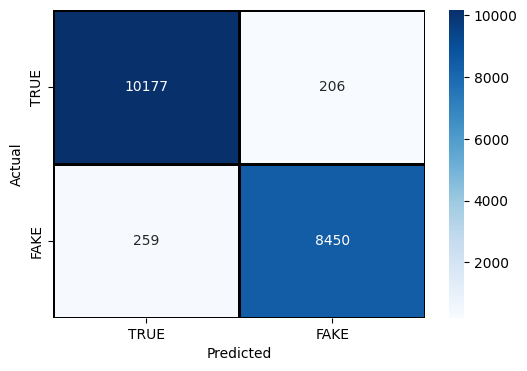

In [ ]:
cm_bilstm = confusion_matrix(y_test,pred.round())
cm_bilstm= pd.DataFrame(cm_bilstm , index = ['TRUE','FAKE'] , columns = ['TRUE','FAKE'])
plt.figure(figsize = (6,4))
sns.heatmap(cm_bilstm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['TRUE','FAKE'] , yticklabels = ['TRUE','FAKE'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test,pred.round()))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10383
           1       0.98      0.97      0.97      8709

    accuracy                           0.98     19092
   macro avg       0.98      0.98      0.98     19092
weighted avg       0.98      0.98      0.98     19092



In [ ]:
ybi_pred = pred.ravel()

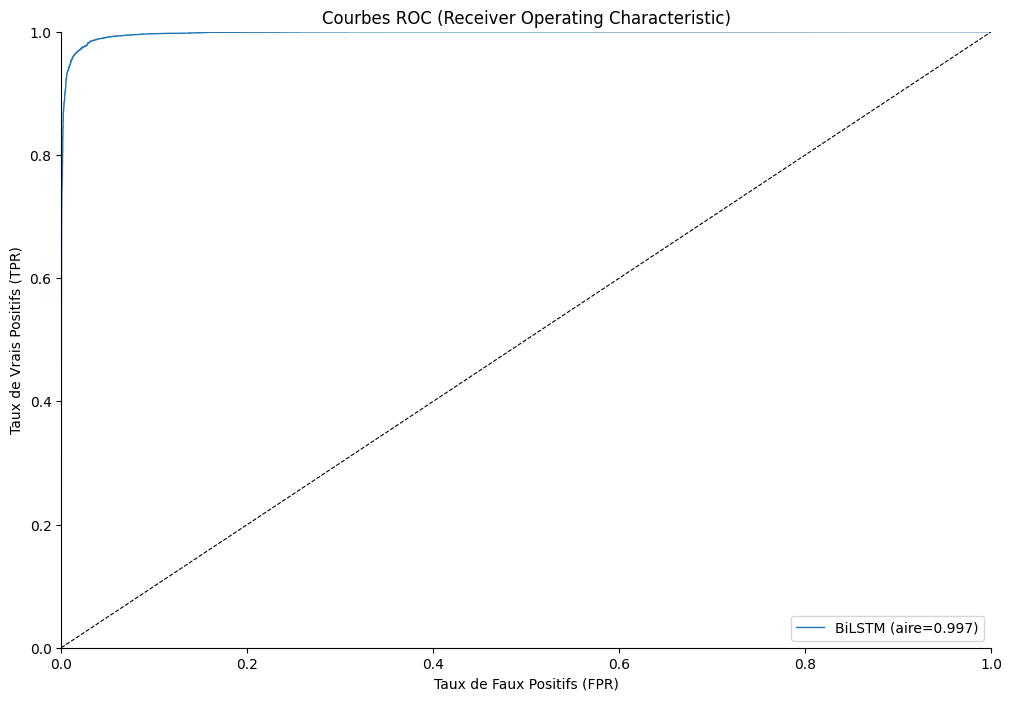

In [ ]:
def roc_auc_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    ax.plot(fpr, tpr, linestyle=l, linewidth=lw,
            label="%s (aire=%.3f)" % (label, roc_auc_score(y_true, y_proba)))

f, ax = plt.subplots(figsize=(12, 8))

# Tracer la courbe ROC pour le modèle BiLSTM
roc_auc_plot(y_test, ybi_pred, label='BiLSTM', l='-')

# Ajouter une ligne de référence
ax.plot([0, 1], [0, 1], color='k', linewidth=0.8, linestyle='--')

# Ajouter une légende et des annotations en français
ax.legend(loc="lower right")
ax.set_xlabel('Taux de Faux Positifs (FPR)')
ax.set_ylabel('Taux de Vrais Positifs (TPR)')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Courbes ROC (Receiver Operating Characteristic)')
sns.despine()


In [ ]:
pred[34]

array([0.0155223], dtype=float32)

# STacked BILSTM

In [ ]:
from keras.layers import Input, LSTM, Dense, GlobalMaxPool1D, SpatialDropout1D

print('Building model with LSTM...')

input_la = Input(shape=(MAX_SEQUENCE_LENGTH,))
aa = embedding_layer(input_la)  # Assurez-vous que cette couche est bien définie
aa = SpatialDropout1D(0.2)(aa)  # Application de SpatialDropout1D après l'embedding
aa = LSTM(64, return_sequences=True)(aa)
#aa = GlobalMaxPool1D()(aa)
aa = LSTM(32)(aa)

aa=Dropout(0.3)(aa)
aa = Dense(64, activation='relu')(aa)

aa=Dropout(0.2)(aa)
outputla = Dense(1, activation="sigmoid")(aa)

model2_lstm = Model(input_la, outputla)

model2_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model2_lstm.summary()

Building model with LSTM...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 800, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 800, 100)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 800, 64)             │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,056,833 (7.85 MB)

 Trainable params: 56,833 (222.00 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
print('Training model...')
ls = model2_lstm.fit(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - accuracy: 0.5541 - loss: 0.6883 - val_accuracy: 0.5985 - val_loss: 0.6722
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.5841 - loss: 0.6748 - val_accuracy: 0.5558 - val_loss: 0.6812
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.5583 - loss: 0.6811 - val_accuracy: 0.5569 - val_loss: 0.6790
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.5582 - loss: 0.6872 - val_accuracy: 0.5483 - val_loss: 0.6878
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.5504 - loss: 0.6878 - val_accuracy: 0.5484 - val_loss: 0.6873
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5496 - loss: 0.6875 - val_accuracy: 0.5484 - val_loss: 0.6873
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.5509 - loss: 0.6869 - val_accuracy: 0.5487 - val_loss: 0.6864
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.5562